In [1]:
!rm -r *
!git clone https://github.com/LudoRey/dip-deblur/
!mv dip-deblur/* ./
!rm -r dip-deblur

Cloning into 'dip-deblur'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 131 (delta 63), reused 85 (delta 31), pack-reused 0
Receiving objects: 100% (131/131), 2.41 MiB | 9.26 MiB/s, done.
Resolving deltas: 100% (63/63), done.


In [4]:
import torch
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from unet import *
from utils import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

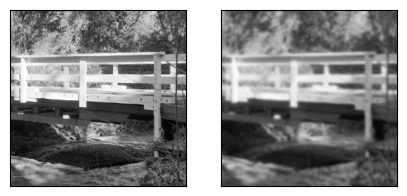

In [38]:
# Read image and create degraded version

filename = 'bridge'
im = read_img('data/'+filename+'.tif', as_tensor=True).to(device)
ker = gaussian_kernel(sigma=1.5, as_tensor=True).to(device)
im_blur = blur(im, ker)
im_blur_noisy = gaussian_noise(im_blur, sigma=1e-2)

fig, axes = plt.subplots(1,2, figsize=(5,10))
axes[0].imshow(to_numpy(im), cmap='gray')
axes[1].imshow(to_numpy(im_blur_noisy), cmap='gray')
for ax in axes:
    ax.tick_params(axis=u'both', which=u'both',length=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
plt.show()

In [39]:
nb_epoch = 2000
learning_rate = 0.01
H, W = im.shape[2], im.shape[3]
input = (torch.rand(1,32,H,W)/10).to(device)
criterion = nn.MSELoss()

net_params = {'feature_channels' : 128, 'skip_channels' : 4, 'depth' : 4}

# Create network
model = Unet(in_channels=input.shape[1], out_channels=1, **net_params)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Optimizing loop
model.train()
for i_epoch in range(nb_epoch):
    optimizer.zero_grad()
    im_recon = model(input)
    loss = criterion(blur(im_recon, ker), im_blur_noisy)
    loss.backward()
    optimizer.step()
    if (i_epoch+1) % 100 == 0:
        metric = psnr(to_numpy(im), to_numpy(im_recon))
        print(' [-] epoch {:}/{:}, loss {:.6f}, psnr {:.5f}'.format(i_epoch+1, nb_epoch, loss.item(), metric))

 [-] epoch 100/2000, loss 0.001560, psnr 21.13068
 [-] epoch 200/2000, loss 0.000402, psnr 22.81097
 [-] epoch 300/2000, loss 0.000265, psnr 23.37328
 [-] epoch 400/2000, loss 0.000200, psnr 23.76416
 [-] epoch 500/2000, loss 0.000218, psnr 23.95846
 [-] epoch 600/2000, loss 0.000150, psnr 24.21641
 [-] epoch 700/2000, loss 0.000142, psnr 24.36809
 [-] epoch 800/2000, loss 0.000156, psnr 24.46316
 [-] epoch 900/2000, loss 0.000126, psnr 24.59975
 [-] epoch 1000/2000, loss 0.000171, psnr 24.62004
 [-] epoch 1100/2000, loss 0.000113, psnr 24.77543
 [-] epoch 1200/2000, loss 0.000110, psnr 24.85331
 [-] epoch 1300/2000, loss 0.000117, psnr 24.91416
 [-] epoch 1400/2000, loss 0.000104, psnr 24.99463
 [-] epoch 1500/2000, loss 0.000102, psnr 25.05722
 [-] epoch 1600/2000, loss 0.000100, psnr 25.11328
 [-] epoch 1700/2000, loss 0.000098, psnr 25.16523
 [-] epoch 1800/2000, loss 0.000097, psnr 25.21599
 [-] epoch 1900/2000, loss 0.000109, psnr 25.23624
 [-] epoch 2000/2000, loss 0.000100, psn

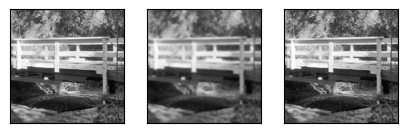

In [40]:
fig, axes = plt.subplots(1,3, figsize=(5,10))
axes[0].imshow(to_numpy(im), cmap='gray')
axes[1].imshow(to_numpy(im_blur_noisy), cmap='gray')
axes[2].imshow(to_numpy(im_recon), cmap='gray')
for ax in axes.flatten():
  ax.tick_params(axis=u'both', which=u'both',length=0)
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  
plt.show()
fig.savefig('figs/'+filename+'.png', dpi=300, bbox_inches='tight', transparent=True)

In [ ]:
# For veil nebula unstretched

ref = read_img('data/veil128_stretched.tif', as_tensor=False)

fig, axes = plt.subplots(1,2, figsize=(10,20))
axes[0].imshow(match_hist(to_numpy(im_blur_noisy), ref), vmin=0, vmax=1, cmap='gray')
axes[1].imshow(match_hist(to_numpy(im_recon), ref), vmin=0, vmax=1, cmap='gray')